In [1]:
# Importar bibliotecas e instalar

# Importar as bibliotecas necessárias para o projeto

# Bibliotecas para manipulação e visualização de dados
import pandas as pd  # Manipulação de dados
import seaborn as sns  # Visualização de dados com gráficos
import networkx as nx  # Construção e visualização de grafos
import matplotlib.pyplot as plt  # Gráficos
import numpy as np  # Operações numéricas

# Biblioteca para dividir dados em treinamento e teste
from sklearn.model_selection import train_test_split

# Biblioteca para avaliar o desempenho dos modelos
from sklearn.metrics import accuracy_score, classification_report, roc_curve, auc, log_loss, roc_auc_score

# Bibliotecas para criação e inferência em redes bayesianas
from pgmpy.models import BayesianNetwork
from pgmpy.estimators import HillClimbSearch, BicScore, K2Score, MaximumLikelihoodEstimator, BayesianEstimator
from pgmpy.inference import VariableElimination
from sklearn.preprocessing import KBinsDiscretizer  # Discretização de variáveis contínuas

# Instalação do nbconvert para exportar notebooks (opcional para VSCode)
# !pip install nbconvert  # Descomentar para instalar se necessário


c:\Users\crish\AppData\Local\Programs\Python\Python312\Lib\site-packages\tqdm\auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


In [92]:
# 1. Exploração e Pré-processamento dos Dados

# Carregar o dataset Titanic diretamente de um URL
url = 'https://raw.githubusercontent.com/datasciencedojo/datasets/master/titanic.csv'
data = pd.read_csv(url)  # Carregar o dataset em um DataFrame


In [93]:
# 1.1 Limpar o DataSet

# Exibir as primeiras linhas do dataset para uma visão inicial
print("Primeiras linhas do dataset:")
print(data.head())

# Verificar valores ausentes em cada coluna
print("\nValores ausentes por coluna:")
print(data.isnull().sum())

# Preencher valores ausentes na coluna 'Age' com a mediana da idade
data['Age'].fillna(data['Age'].median(), inplace=True)

# Preencher valores ausentes na coluna 'Embarked' com o valor mais frequente
data['Embarked'].fillna(data['Embarked'].mode()[0], inplace=True)

# Excluir a coluna 'Cabin' devido ao grande número de valores ausentes
data.drop(columns=['Cabin'], inplace=True)

# Converter a coluna 'Sex' de categórica para numérica (0 = male, 1 = female)
data['Sex'] = data['Sex'].map({'male': 0, 'female': 1})

# Converter a coluna 'Embarked' de categórica para numérica (S = 0, C = 1, Q = 2)
data['Embarked'] = data['Embarked'].map({'S': 0, 'C': 1, 'Q': 2})

# Selecionar as colunas relevantes para o modelo
data = data[['Survived', 'Pclass', 'Sex', 'Age', 'SibSp', 'Parch', 'Fare', 'Embarked']]


Primeiras linhas do dataset:
   PassengerId  Survived  Pclass  \
0            1         0       3   
1            2         1       1   
2            3         1       3   
3            4         1       1   
4            5         0       3   

                                                Name     Sex   Age  SibSp  \
0                            Braund, Mr. Owen Harris    male  22.0      1   
1  Cumings, Mrs. John Bradley (Florence Briggs Th...  female  38.0      1   
2                             Heikkinen, Miss. Laina  female  26.0      0   
3       Futrelle, Mrs. Jacques Heath (Lily May Peel)  female  35.0      1   
4                           Allen, Mr. William Henry    male  35.0      0   

   Parch            Ticket     Fare Cabin Embarked  
0      0         A/5 21171   7.2500   NaN        S  
1      0          PC 17599  71.2833   C85        C  
2      0  STON/O2. 3101282   7.9250   NaN        S  
3      0            113803  53.1000  C123        S  
4      0            373450

In [94]:
# Estruturação da Rede Bayesiana

# Discretizar as colunas 'Age' e 'Fare' para uso na rede bayesiana

# Configurar o discretizador para dividir a idade em 5 faixas de frequência semelhante (quantile)
age_discretizer = KBinsDiscretizer(n_bins=5, encode='ordinal', strategy='quantile')
data['Age'] = age_discretizer.fit_transform(data[['Age']]).astype(int)

# Discretizar 'Fare' em 4 faixas (quartis)
data['Fare'] = pd.qcut(data['Fare'], 4, labels=[0, 1, 2, 3]).astype(int)

# Converter todas as colunas para tipo inteiro (necessário para modelos bayesianos)
data = data.astype(int)

# Verificar os dados após a discretização
print("\nDados após a discretização de 'Age' com KBinsDiscretizer:")
print(data.head())

# Verificar os dados após o pré-processamento
print("\nDados após o pré-processamento:")
print(data.head())



Dados após a discretização de 'Age' com KBinsDiscretizer:
   Survived  Pclass  Sex  Age  SibSp  Parch  Fare  Embarked
0         0       3    0    1      1      0     0         0
1         1       1    1    3      1      0     3         1
2         1       3    1    1      0      0     1         0
3         1       1    1    2      1      0     3         0
4         0       3    0    2      0      0     1         0

Dados após o pré-processamento:
   Survived  Pclass  Sex  Age  SibSp  Parch  Fare  Embarked
0         0       3    0    1      1      0     0         0
1         1       1    1    3      1      0     3         1
2         1       3    1    1      0      0     1         0
3         1       1    1    2      1      0     3         0
4         0       3    0    2      0      0     1         0


c:\Users\crish\AppData\Local\Programs\Python\Python312\Lib\site-packages\sklearn\preprocessing\_discretization.py:307: UserWarning: Bins whose width are too small (i.e., <= 1e-8) in feature 0 are removed. Consider decreasing the number of bins.
  warnings.warn(


In [95]:
# Estatísticas descritivas do dataset

print("\nEstatísticas descritivas do dataset:\n")
print(data.describe())



Estatísticas descritivas do dataset:

         Survived      Pclass         Sex         Age       SibSp       Parch  \
count  891.000000  891.000000  891.000000  891.000000  891.000000  891.000000   
mean     0.383838    2.308642    0.352413    1.648709    0.523008    0.381594   
std      0.486592    0.836071    0.477990    1.009531    1.102743    0.806057   
min      0.000000    1.000000    0.000000    0.000000    0.000000    0.000000   
25%      0.000000    2.000000    0.000000    1.000000    0.000000    0.000000   
50%      0.000000    3.000000    0.000000    2.000000    0.000000    0.000000   
75%      1.000000    3.000000    1.000000    2.000000    1.000000    0.000000   
max      1.000000    3.000000    1.000000    3.000000    8.000000    6.000000   

             Fare    Embarked  
count  891.000000  891.000000  
mean     1.497194    0.361392  
std      1.118156    0.635673  
min      0.000000    0.000000  
25%      0.500000    0.000000  
50%      1.000000    0.000000  
75%    

INFO:matplotlib.category:Using categorical units to plot a list of strings that are all parsable as floats or dates. If these strings should be plotted as numbers, cast to the appropriate data type before plotting.
INFO:matplotlib.category:Using categorical units to plot a list of strings that are all parsable as floats or dates. If these strings should be plotted as numbers, cast to the appropriate data type before plotting.


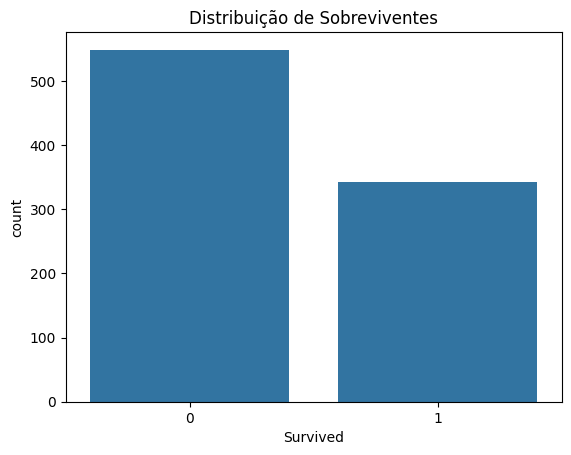

INFO:matplotlib.category:Using categorical units to plot a list of strings that are all parsable as floats or dates. If these strings should be plotted as numbers, cast to the appropriate data type before plotting.
INFO:matplotlib.category:Using categorical units to plot a list of strings that are all parsable as floats or dates. If these strings should be plotted as numbers, cast to the appropriate data type before plotting.


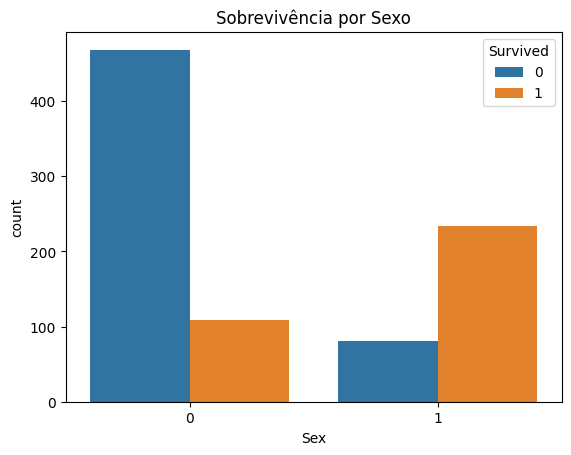

INFO:matplotlib.category:Using categorical units to plot a list of strings that are all parsable as floats or dates. If these strings should be plotted as numbers, cast to the appropriate data type before plotting.
INFO:matplotlib.category:Using categorical units to plot a list of strings that are all parsable as floats or dates. If these strings should be plotted as numbers, cast to the appropriate data type before plotting.


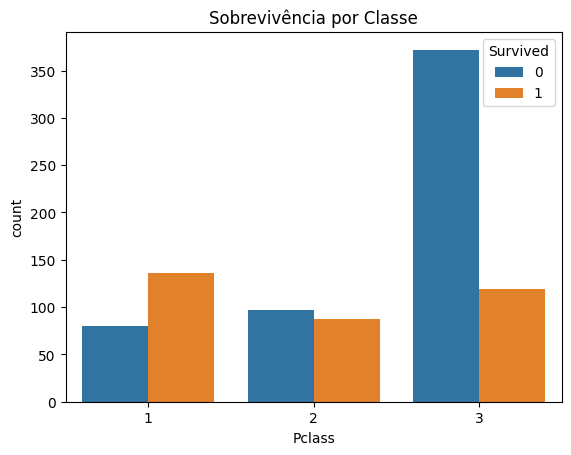

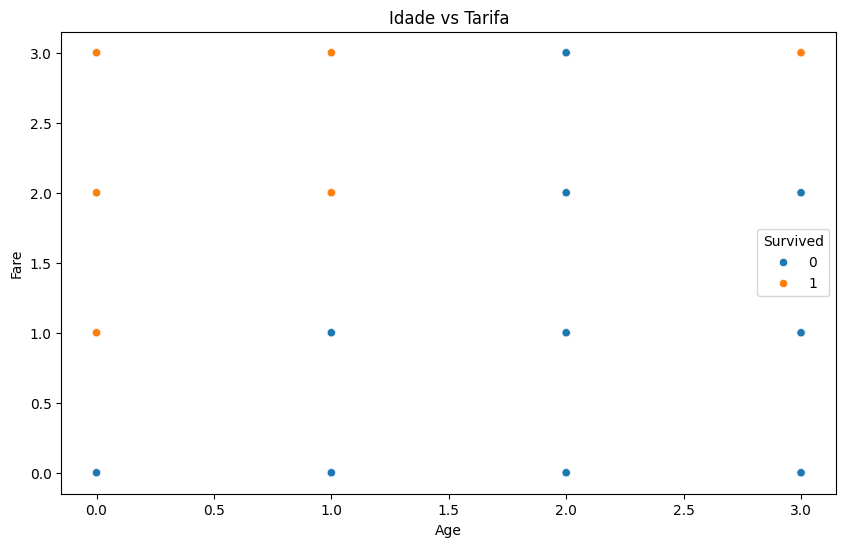

INFO:matplotlib.category:Using categorical units to plot a list of strings that are all parsable as floats or dates. If these strings should be plotted as numbers, cast to the appropriate data type before plotting.
INFO:matplotlib.category:Using categorical units to plot a list of strings that are all parsable as floats or dates. If these strings should be plotted as numbers, cast to the appropriate data type before plotting.


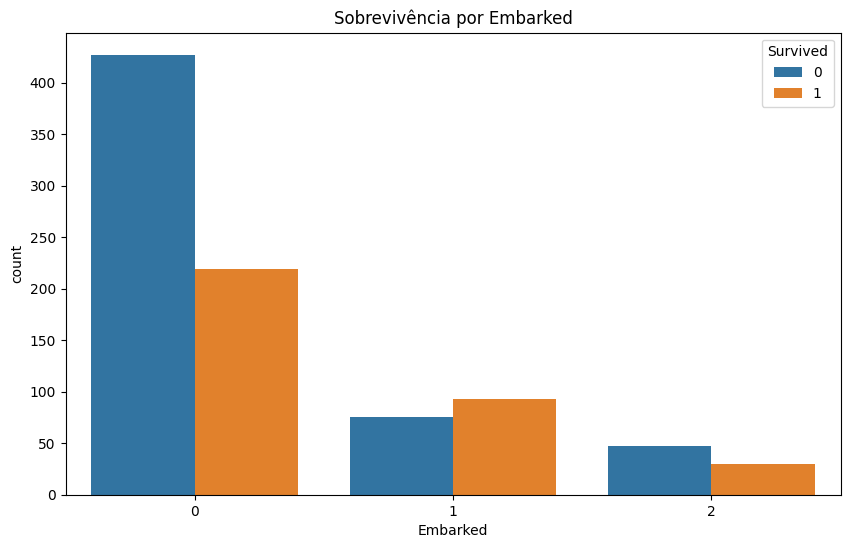

INFO:matplotlib.category:Using categorical units to plot a list of strings that are all parsable as floats or dates. If these strings should be plotted as numbers, cast to the appropriate data type before plotting.
INFO:matplotlib.category:Using categorical units to plot a list of strings that are all parsable as floats or dates. If these strings should be plotted as numbers, cast to the appropriate data type before plotting.


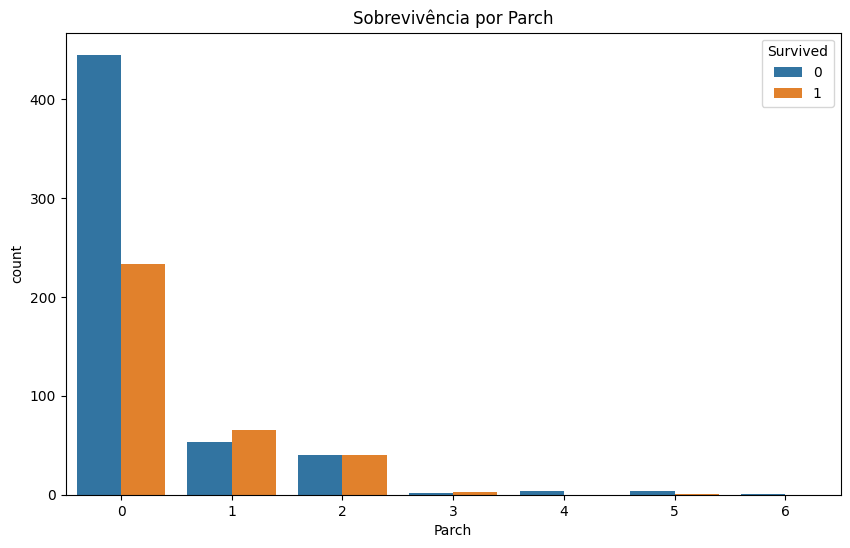

INFO:matplotlib.category:Using categorical units to plot a list of strings that are all parsable as floats or dates. If these strings should be plotted as numbers, cast to the appropriate data type before plotting.
INFO:matplotlib.category:Using categorical units to plot a list of strings that are all parsable as floats or dates. If these strings should be plotted as numbers, cast to the appropriate data type before plotting.


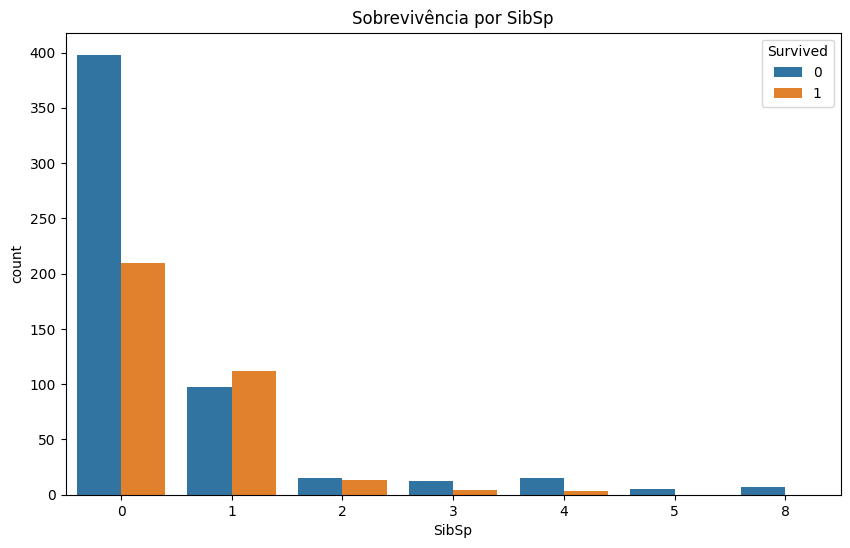

In [96]:
# Visualização dos Dados

# Gráfico de contagem de sobreviventes
sns.countplot(x='Survived', data=data)
plt.title('Distribuição de Sobreviventes')
plt.show()

# Gráfico de sobrevivência por sexo
sns.countplot(x='Sex', hue='Survived', data=data)
plt.title('Sobrevivência por Sexo')
plt.show()

# Gráfico de sobrevivência por classe
sns.countplot(x='Pclass', hue='Survived', data=data)
plt.title('Sobrevivência por Classe')
plt.show()

# Gráfico de dispersão para 'Age' vs 'Fare'
plt.figure(figsize=(10, 6))
sns.scatterplot(x='Age', y='Fare', hue='Survived', data=data)
plt.title('Idade vs Tarifa')
plt.show()

# Gráfico de sobrevivência por 'Embarked'
plt.figure(figsize=(10, 6))
sns.countplot(x='Embarked', hue='Survived', data=data)
plt.title('Sobrevivência por Embarked')
plt.show()

# Gráfico de sobrevivência por 'Parch'
plt.figure(figsize=(10, 6))
sns.countplot(x='Parch', hue='Survived', data=data)
plt.title('Sobrevivência por Parch')
plt.show()

# Gráfico de sobrevivência por 'SibSp'
plt.figure(figsize=(10, 6))
sns.countplot(x='SibSp', hue='Survived', data=data)
plt.title('Sobrevivência por SibSp')
plt.show()


In [97]:
# Seleção de Variáveis com Mutual Information

from sklearn.feature_selection import mutual_info_classif

# Definir as variáveis independentes e a variável alvo
X = data.drop('Survived', axis=1)
y = data['Survived']

# Calcular a mutual information
mi = mutual_info_classif(X, y, discrete_features=True)

# Exibir a importância das variáveis
importance = pd.Series(mi, index=X.columns)
importance.sort_values(ascending=False, inplace=True)
print("Importância das variáveis (Mutual Information):")
print(importance)


Importância das variáveis (Mutual Information):
Sex         0.150870
Pclass      0.058107
Fare        0.046180
SibSp       0.023197
Parch       0.016366
Embarked    0.014233
Age         0.004641
dtype: float64


In [98]:
# Treinamento BIC

# Separar a variável alvo ('Survived') das variáveis preditoras
X = data.drop('Survived', axis=1)
y = data['Survived']

# Dividir os dados em conjuntos de treinamento e teste
train_data, test_data = train_test_split(data, test_size=0.2, random_state=42, stratify=data['Survived'])

print(f"\nConjunto de Treinamento: {len(train_data)} registros")
print(f"Conjunto de Teste: {len(test_data)} registros")

# Treinar o modelo usando Hill Climbing com o BIC Score
est_hc = HillClimbSearch(train_data)
best_model_bic = est_hc.estimate(scoring_method=BicScore(train_data))

# Criar e treinar o modelo de rede bayesiana com a estrutura BIC encontrada
model_bic = BayesianNetwork(best_model_bic.edges())
model_bic.fit(train_data, estimator=BayesianEstimator, prior_type='BDeu')



Conjunto de Treinamento: 712 registros
Conjunto de Teste: 179 registros


  0%|          | 7/1000000 [00:00<8:21:02, 33.26it/s] 


In [99]:
# Treinamento K2

# Treinar o modelo usando Hill Climbing com o K2 Score
k2score = K2Score(train_data)
best_model_k2 = est_hc.estimate(scoring_method=k2score)

# Criar e treinar o modelo de rede bayesiana com a estrutura K2 encontrada
model_k2 = BayesianNetwork(best_model_k2.edges())
model_k2.fit(train_data, estimator=BayesianEstimator, prior_type='BDeu')


  0%|          | 27/1000000 [00:00<3:39:26, 75.95it/s]


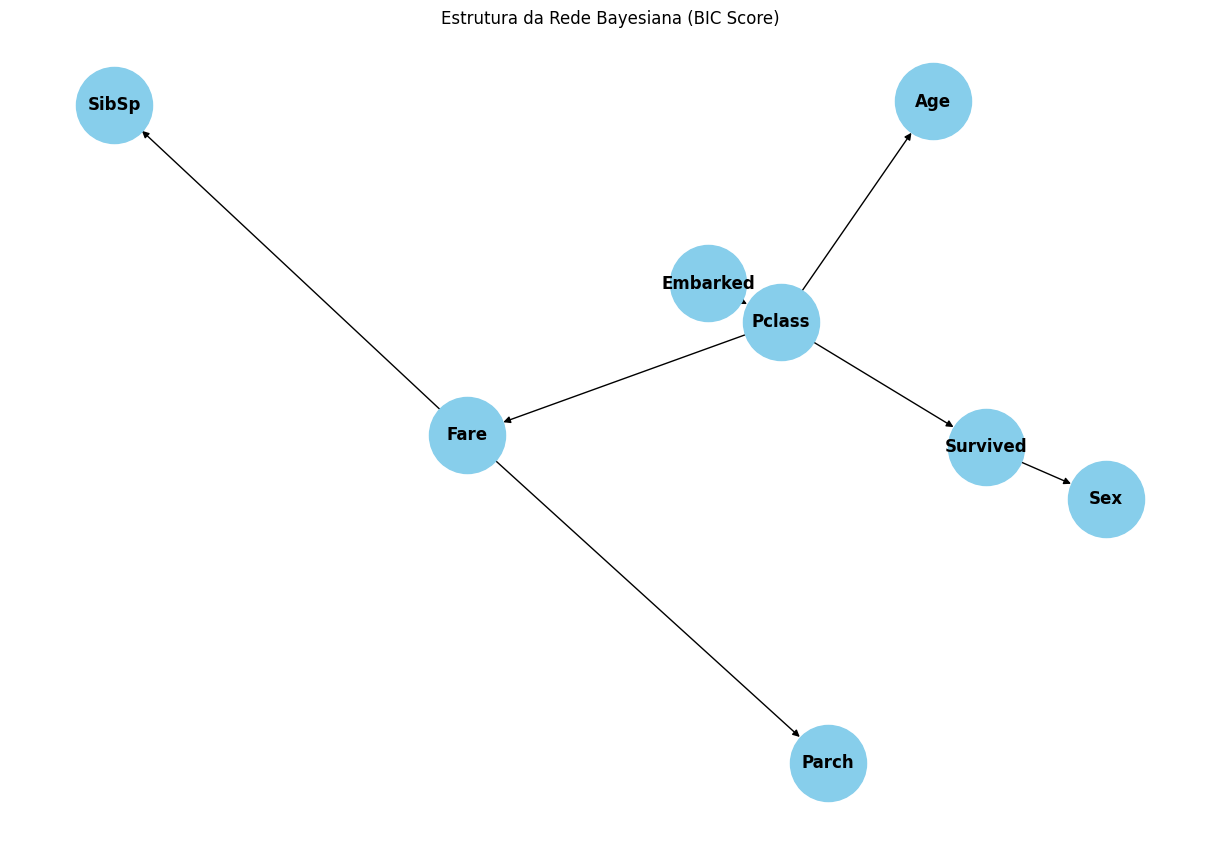

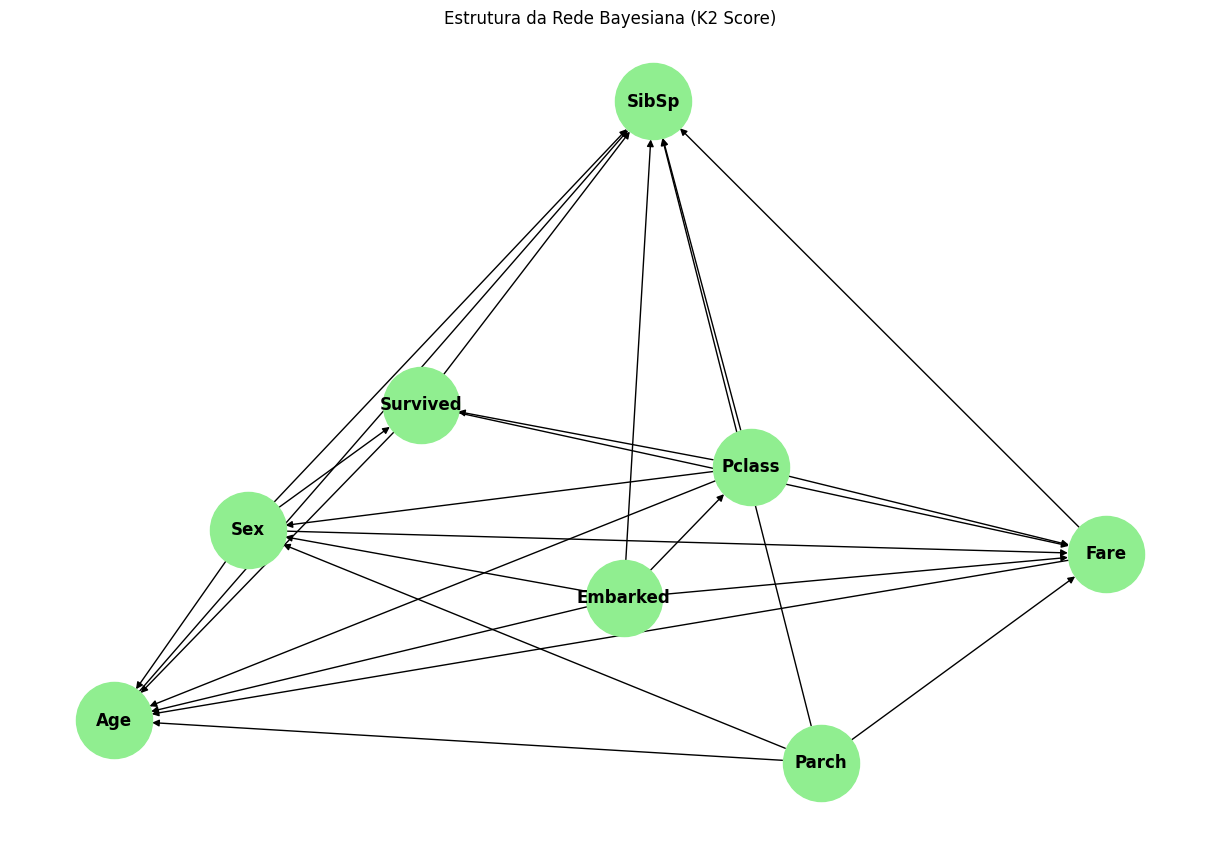

In [100]:
# Visualização das Estruturas da Rede Bayesiana

# Estrutura com BIC Score
plt.figure(figsize=(12, 8))
G_bic = nx.DiGraph(model_bic.edges())
pos_bic = nx.spring_layout(G_bic, seed=42)
nx.draw(G_bic, pos_bic, with_labels=True, node_size=3000, node_color="skyblue",
        font_size=12, font_weight="bold", arrows=True)
plt.title("Estrutura da Rede Bayesiana (BIC Score)")
plt.show()

# Estrutura com K2 Score
plt.figure(figsize=(12, 8))
G_k2 = nx.DiGraph(model_k2.edges())
pos_k2 = nx.spring_layout(G_k2, seed=42)
nx.draw(G_k2, pos_k2, with_labels=True, node_size=3000, node_color="lightgreen",
        font_size=12, font_weight="bold", arrows=True)
plt.title("Estrutura da Rede Bayesiana (K2 Score)")
plt.show()


In [101]:
# Treinamento e Ajuste de Hiperparâmetros

# Nesta seção, exploraremos como ajustar diferentes hiperparâmetros para melhorar o desempenho dos modelos de rede bayesiana.
# Ajustaremos parâmetros como o tipo de prior e o tamanho de amostra equivalente no BayesianEstimator.

# Definir diferentes configurações para o BayesianEstimator
estimator_configs = [
    {'prior_type': 'BDeu', 'equivalent_sample_size': 1},
    {'prior_type': 'BDeu', 'equivalent_sample_size': 10},
    {'prior_type': 'BDeu', 'equivalent_sample_size': 20},
    # Adicione mais configurações conforme necessário
]

# Lista para armazenar os melhores modelos com diferentes configurações
best_models = []

# Iterar sobre as configurações do estimador
for est_config in estimator_configs:
    # Estimar a estrutura usando o BIC Score
    est_hc = HillClimbSearch(train_data)
    best_model_bic = est_hc.estimate(scoring_method=BicScore(train_data))
    
    # Criar o modelo de rede bayesiana com as arestas encontradas
    model_bic = BayesianNetwork(best_model_bic.edges())
    
    # Ajustar o modelo com o BayesianEstimator usando a configuração atual
    model_bic.fit(train_data, estimator=BayesianEstimator, prior_type=est_config['prior_type'], equivalent_sample_size=est_config['equivalent_sample_size'])
    
    # Adicionar o modelo treinado e sua configuração à lista
    best_models.append({
        'model': model_bic,
        'estimator_config': est_config
    })
    
    # Opcional: Exibir a configuração atual
    print(f"Modelo BIC treinado com configuração: {est_config}")


  0%|          | 7/1000000 [00:00<5:11:35, 53.49it/s]


Modelo BIC treinado com configuração: {'prior_type': 'BDeu', 'equivalent_sample_size': 1}


  0%|          | 7/1000000 [00:00<5:24:38, 51.34it/s]


Modelo BIC treinado com configuração: {'prior_type': 'BDeu', 'equivalent_sample_size': 10}


  0%|          | 7/1000000 [00:00<7:25:28, 37.41it/s]

Modelo BIC treinado com configuração: {'prior_type': 'BDeu', 'equivalent_sample_size': 20}


In [ ]:
# Treinamento BIC com Diferentes Hiperparâmetros

# Nesta seção, vamos focar no treinamento do modelo usando o BIC Score com diferentes configurações no BayesianEstimator.

# Definir diferentes configurações específicas para o BIC Score
bic_estimator_configs = [
    {'prior_type': 'BDeu', 'equivalent_sample_size': 1},
    {'prior_type': 'BDeu', 'equivalent_sample_size': 10},
    {'prior_type': 'BDeu', 'equivalent_sample_size': 20},
    # Adicione mais configurações conforme necessário
]

# Lista para armazenar os modelos BIC treinados com diferentes hiperparâmetros
bic_models = []

# Iterar sobre as configurações do estimador para BIC
for est_config in bic_estimator_configs:
    # Estimar a estrutura usando o BIC Score
    est_hc_bic = HillClimbSearch(train_data)
    best_model_bic = est_hc_bic.estimate(scoring_method=BicScore(train_data))
    
    # Criar o modelo de rede bayesiana com as arestas encontradas
    model_bic = BayesianNetwork(best_model_bic.edges())
    
    # Ajustar o modelo com o BayesianEstimator usando a configuração atual
    model_bic.fit(train_data, estimator=BayesianEstimator, prior_type=est_config['prior_type'], equivalent_sample_size=est_config['equivalent_sample_size'])
    
    # Adicionar o modelo treinado e sua configuração à lista
    bic_models.append({
        'model': model_bic,
        'estimator_config': est_config
    })
    
    # Opcional: Exibir a configuração atual
    print(f"Modelo BIC treinado com configuração: {est_config}")


  0%|          | 7/1000000 [00:00<4:57:02, 56.11it/s]


Modelo BIC treinado com configuração: {'prior_type': 'BDeu', 'equivalent_sample_size': 1}


  0%|          | 7/1000000 [00:00<5:30:02, 50.50it/s]


Modelo BIC treinado com configuração: {'prior_type': 'BDeu', 'equivalent_sample_size': 10}


  0%|          | 7/1000000 [00:00<6:54:13, 40.24it/s]


Modelo BIC treinado com configuração: {'prior_type': 'BDeu', 'equivalent_sample_size': 20}


In [103]:
# Treinamento K2 com Diferentes Hiperparâmetros

# Nesta seção, vamos focar no treinamento do modelo usando o K2 Score com diferentes configurações no BayesianEstimator.

# Definir diferentes configurações específicas para o K2 Score
k2_estimator_configs = [
    {'prior_type': 'BDeu', 'equivalent_sample_size': 1},
    {'prior_type': 'BDeu', 'equivalent_sample_size': 10},
    {'prior_type': 'BDeu', 'equivalent_sample_size': 20},
    # Adicione mais configurações conforme necessário
]

# Lista para armazenar os modelos K2 treinados com diferentes hiperparâmetros
k2_models = []

# Iterar sobre as configurações do estimador para K2
for est_config in k2_estimator_configs:
    # Estimar a estrutura usando o K2 Score
    est_hc_k2 = HillClimbSearch(train_data)
    best_model_k2 = est_hc_k2.estimate(scoring_method=K2Score(train_data))
    
    # Criar o modelo de rede bayesiana com as arestas encontradas
    model_k2 = BayesianNetwork(best_model_k2.edges())
    
    # Ajustar o modelo com o BayesianEstimator usando a configuração atual
    model_k2.fit(train_data, estimator=BayesianEstimator, prior_type=est_config['prior_type'], equivalent_sample_size=est_config['equivalent_sample_size'])
    
    # Adicionar o modelo treinado e sua configuração à lista
    k2_models.append({
        'model': model_k2,
        'estimator_config': est_config
    })
    
    # Opcional: Exibir a configuração atual
    print(f"Modelo K2 treinado com configuração: {est_config}")


  0%|          | 27/1000000 [00:00<4:42:21, 59.03it/s]


Modelo K2 treinado com configuração: {'prior_type': 'BDeu', 'equivalent_sample_size': 1}


  0%|          | 27/1000000 [00:00<4:30:47, 61.54it/s]


Modelo K2 treinado com configuração: {'prior_type': 'BDeu', 'equivalent_sample_size': 10}


  0%|          | 27/1000000 [00:00<3:00:44, 92.21it/s]


Modelo K2 treinado com configuração: {'prior_type': 'BDeu', 'equivalent_sample_size': 20}


In [104]:
# Avaliação do Modelo

# Função para realizar predições usando inferência nas redes bayesianas
def predict(model, data, evidence_vars, target_var='Survived'):
    inference = VariableElimination(model)
    predictions = []
    for idx, row in data.iterrows():
        evidence = {var: row[var] for var in evidence_vars}
        try:
            query_result = inference.query(variables=[target_var], evidence=evidence)
            prob = query_result.values
            predicted_state = np.argmax(prob)
            predictions.append(int(predicted_state))
        except Exception as e:
            predictions.append(0)  # Valor padrão em caso de erro
    return predictions

# Definir as variáveis de evidência
evidence_vars = data.columns.tolist()
evidence_vars.remove('Survived')


In [105]:
# Avaliação BIC

# Realizar predições no conjunto de teste usando o modelo BIC
predictions_bic = predict(model_bic, test_data, evidence_vars)
accuracy_bic = accuracy_score(test_data['Survived'], predictions_bic)
print(f"\nAcurácia do Modelo BIC no Conjunto de Teste: {accuracy_bic:.4f}")



Acurácia do Modelo BIC no Conjunto de Teste: 0.7765


In [106]:
# Avaliação K2

# Realizar predições no conjunto de teste usando o modelo K2
predictions_k2 = predict(model_k2, test_data, evidence_vars)
accuracy_k2 = accuracy_score(test_data['Survived'], predictions_k2)
print(f"\nAcurácia do Modelo K2 no Conjunto de Teste: {accuracy_k2:.4f}")



Acurácia do Modelo K2 no Conjunto de Teste: 0.7095


In [107]:
# Avaliação do Modelo com Métricas Adicionais

import numpy as np
import pandas as pd
from pgmpy.inference import VariableElimination
from sklearn.metrics import accuracy_score, log_loss, roc_auc_score
from sklearn.model_selection import train_test_split

# Função de predição com probabilidade
def predict(model, data, evidence_vars, target_var='Survived'):
    """
    Realiza predições utilizando o modelo fornecido.

    Args:
        model: Modelo treinado (BIC ou K2).
        data (pd.DataFrame): Dados para predição.
        evidence_vars (list): Lista de variáveis de evidência.
        target_var (str): Variável alvo (padrão 'Survived').

    Returns:
        predictions (list): Lista de classes previstas.
        probabilities (list): Lista de probabilidades da classe positiva.
    """
    inference = VariableElimination(model)
    predictions = []
    probabilities = []
    for idx, row in data.iterrows():
        evidence = {var: row[var] for var in evidence_vars}
        try:
            query_result = inference.query(variables=[target_var], evidence=evidence)
            prob = query_result.values
            predicted_state = np.argmax(prob)
            predictions.append(int(predicted_state))
            # Assumindo que a classe positiva é '1'
            probabilities.append(prob[1] if len(prob) > 1 else prob[0])
        except Exception as e:
            print(f"Erro na linha {idx}: {e}")
            predictions.append(0)
            probabilities.append(0.0)
    return predictions, probabilities

# Definir as variáveis de evidência
evidence_vars = test_data.columns.tolist()
if 'Survived' not in evidence_vars:
    print("A variável 'Survived' não está presente no test_data.")
else:
    evidence_vars.remove('Survived')  # Remover a variável alvo

# Verificar se todas as variáveis de evidência estão presentes no modelo
model_vars = model_bic.nodes()
missing_vars_model = [var for var in evidence_vars if var not in model_vars]
if missing_vars_model:
    print(f"As seguintes variáveis de evidência não estão presentes no modelo BIC: {missing_vars_model}")

# Avaliar o modelo BIC
predictions_bic, probabilities_bic = predict(model_bic, test_data, evidence_vars)
logloss_bic = log_loss(test_data['Survived'], probabilities_bic)
# Verificar se há pelo menos duas classes para calcular o AUC
if len(test_data['Survived'].unique()) > 1:
    auc_bic = roc_auc_score(test_data['Survived'], probabilities_bic)
else:
    auc_bic = float('nan')  # Não é possível calcular o AUC com uma única classe

print(f"\n=== Avaliação do Modelo BIC ===")
print(f"Entropia Cruzada (Log Loss): {logloss_bic:.4f}")
print(f"AUC-ROC: {auc_bic:.4f}")

# Avaliar o modelo K2
predictions_k2, probabilities_k2 = predict(model_k2, test_data, evidence_vars)
logloss_k2 = log_loss(test_data['Survived'], probabilities_k2)
# Verificar se há pelo menos duas classes para calcular o AUC
if len(test_data['Survived'].unique()) > 1:
    auc_k2 = roc_auc_score(test_data['Survived'], probabilities_k2)
else:
    auc_k2 = float('nan')  # Não é possível calcular o AUC com uma única classe

print(f"\n=== Avaliação do Modelo K2 ===")
print(f"Entropia Cruzada (Log Loss): {logloss_k2:.4f}")
print(f"AUC-ROC: {auc_k2:.4f}")



=== Avaliação do Modelo BIC ===
Entropia Cruzada (Log Loss): 0.4825
AUC-ROC: 0.8217

=== Avaliação do Modelo K2 ===
Entropia Cruzada (Log Loss): 0.8203
AUC-ROC: 0.7550


In [108]:
# Discussão dos Resultados

# Discussão das métricas de desempenho dos modelos BIC e K2
print("\n=== Discussão dos Resultados ===\n")

print(f"A Entropia Cruzada (Log Loss) do Modelo BIC é {logloss_bic:.4f}")
print(f"O AUC-ROC do Modelo BIC é {auc_bic:.4f}")
print(f"A Entropia Cruzada (Log Loss) do Modelo K2 é {logloss_k2:.4f}")
print(f"O AUC-ROC do Modelo K2 é {auc_k2:.4f}")

print("""
Analisando as métricas de Entropia Cruzada e AUC-ROC, podemos observar:

- **Entropia Cruzada (Log Loss)**: Avalia a confiança das previsões, penalizando erros de forma mais intensa.
- **AUC-ROC**: Mede a capacidade do modelo de distinguir entre as classes, útil para dados desbalanceados.

Comparando os dois modelos, a análise das métricas indica possíveis áreas de melhoria, como:

- **Incluir mais variáveis**: Considerar outras características presentes no dataset.
- **Ajustar a discretização**: Experimentar diferentes formas de discretizar variáveis contínuas.
- **Experimentar outros algoritmos**: Como o PC Algorithm ou métodos híbridos.
""")



=== Discussão dos Resultados ===

A Entropia Cruzada (Log Loss) do Modelo BIC é 0.4825
O AUC-ROC do Modelo BIC é 0.8217
A Entropia Cruzada (Log Loss) do Modelo K2 é 0.8203
O AUC-ROC do Modelo K2 é 0.7550

Analisando as métricas de Entropia Cruzada e AUC-ROC, podemos observar:

- **Entropia Cruzada (Log Loss)**: Avalia a confiança das previsões, penalizando erros de forma mais intensa.
- **AUC-ROC**: Mede a capacidade do modelo de distinguir entre as classes, útil para dados desbalanceados.

Comparando os dois modelos, a análise das métricas indica possíveis áreas de melhoria, como:

- **Incluir mais variáveis**: Considerar outras características presentes no dataset.
- **Ajustar a discretização**: Experimentar diferentes formas de discretizar variáveis contínuas.
- **Experimentar outros algoritmos**: Como o PC Algorithm ou métodos híbridos.



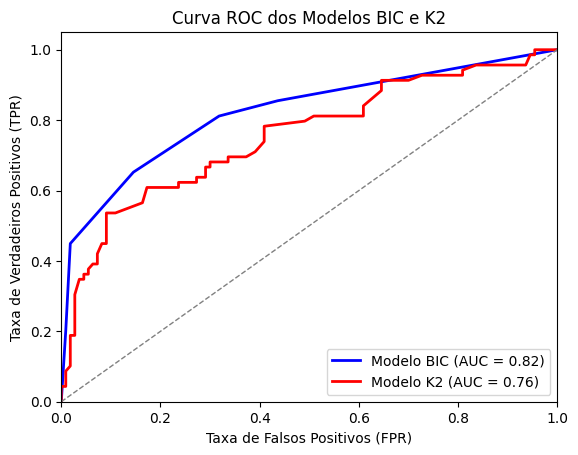

In [109]:
# Plotar Curvas ROC

import matplotlib.pyplot as plt
from sklearn.metrics import roc_curve, auc

# Calcular as curvas ROC
fpr_bic, tpr_bic, _ = roc_curve(test_data['Survived'], probabilities_bic)
roc_auc_bic = auc(fpr_bic, tpr_bic)

fpr_k2, tpr_k2, _ = roc_curve(test_data['Survived'], probabilities_k2)
roc_auc_k2 = auc(fpr_k2, tpr_k2)

# Plotar as curvas ROC
plt.figure()
plt.plot(fpr_bic, tpr_bic, color='blue', lw=2, label=f'Modelo BIC (AUC = {roc_auc_bic:.2f})')
plt.plot(fpr_k2, tpr_k2, color='red', lw=2, label=f'Modelo K2 (AUC = {roc_auc_k2:.2f})')
plt.plot([0, 1], [0, 1], color='gray', lw=1, linestyle='--')
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.05])
plt.xlabel('Taxa de Falsos Positivos (FPR)')
plt.ylabel('Taxa de Verdadeiros Positivos (TPR)')
plt.title('Curva ROC dos Modelos BIC e K2')
plt.legend(loc='lower right')
plt.show()


In [110]:
# Seleção das 7 Variáveis Mais Importantes

# Nesta seção, selecionaremos as 7 variáveis mais importantes com base na Informação Mútua calculada anteriormente.
# Isso ajudará a focar nas variáveis que mais contribuem para a previsão da sobrevivência dos passageiros.

# Supondo que a série de Informação Mútua esteja armazenada na variável 'importance'
top_7_features = importance.head(7)  # Seleciona as 7 primeiras variáveis com maior Informação Mútua
print("Top 7 variáveis mais importantes com base na Informação Mútua:")
print(top_7_features)

# Criar uma nova tabela com as 7 variáveis mais importantes + a coluna alvo 'Survived'
top_7_vars = top_7_features.index.tolist()  # Obtém os nomes das 7 variáveis
new_df = data[top_7_vars + ['Survived']]  # Cria a nova tabela com as variáveis selecionadas e a coluna alvo

# Exibir as primeiras linhas da nova tabela para verificação
print("\nNova tabela com as 7 variáveis mais importantes e a coluna alvo:")
print(new_df.head(50))

# Salvar a nova tabela em um arquivo CSV para uso futuro ou compartilhamento
new_df.to_csv('top_7_features_table.csv', index=False)
print("Nova tabela salva como 'top_7_features_table.csv'")


Top 7 variáveis mais importantes com base na Informação Mútua:
Sex         0.150870
Pclass      0.058107
Fare        0.046180
SibSp       0.023197
Parch       0.016366
Embarked    0.014233
Age         0.004641
dtype: float64

Nova tabela com as 7 variáveis mais importantes e a coluna alvo:
    Sex  Pclass  Fare  SibSp  Parch  Embarked  Age  Survived
0     0       3     0      1      0         0    1         0
1     1       1     3      1      0         1    3         1
2     1       3     1      0      0         0    1         1
3     1       1     3      1      0         0    2         1
4     0       3     1      0      0         0    2         0
5     0       3     1      0      0         2    2         0
6     0       1     3      0      0         0    3         0
7     0       3     2      3      1         0    0         0
8     1       3     1      0      2         0    1         1
9     1       2     2      1      0         1    0         1
10    1       3     2      1      1   

In [ ]:
import pandas as pd
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import KBinsDiscretizer
from pgmpy.models import BayesianNetwork
from pgmpy.estimators import HillClimbSearch, BicScore, K2Score, BayesianEstimator
import networkx as nx
import matplotlib.pyplot as plt

# Passo 1: Carregar o arquivo CSV que contém as colunas mais importantes para análise
df = pd.read_csv('./top_7_features_table.csv')

# Passo 2: Amostragem aleatória de 22405 linhas para facilitar o processamento
df = df.sample(n=22405, random_state=42)

# Passo 3: Pré-processamento dos dados
# Exibir as primeiras linhas do dataset
print("Primeiras linhas do dataset:")
print(df.head())

# Verificar e preencher valores ausentes
print("\nValores ausentes por coluna:")
print(df.isnull().sum())

# Preencher valores ausentes em 'Age' com a mediana
if 'Age' in df.columns:
    df['Age'].fillna(df['Age'].median(), inplace=True)

# Preencher valores ausentes em 'Embarked' com o valor mais frequente
if 'Embarked' in df.columns:
    df['Embarked'].fillna(df['Embarked'].mode()[0], inplace=True)

# Excluir a coluna 'Cabin' devido ao grande número de valores ausentes, se existir
if 'Cabin' in df.columns:
    df.drop(columns=['Cabin'], inplace=True)

# Converter 'Sex' para valores numéricos
if 'Sex' in df.columns:
    df['Sex'] = df['Sex'].map({'male': 0, 'female': 1})

# Converter 'Embarked' para valores numéricos
if 'Embarked' in df.columns:
    df['Embarked'] = df['Embarked'].map({'S': 0, 'C': 1, 'Q': 2})

# Selecionar as colunas relevantes
relevant_columns = ['Survived', 'Pclass', 'Sex', 'Age', 'SibSp', 'Parch', 'Fare', 'Embarked']
df = df[relevant_columns]

# Discretizar 'Age' e 'Fare' usando KBinsDiscretizer
age_discretizer = KBinsDiscretizer(n_bins=5, encode='ordinal', strategy='quantile')
fare_discretizer = KBinsDiscretizer(n_bins=4, encode='ordinal', strategy='quantile')

# Ajustar e transformar a coluna 'Age'
df['Age'] = age_discretizer.fit_transform(df[['Age']]).astype(int)

# Ajustar e transformar a coluna 'Fare'
df['Fare'] = fare_discretizer.fit_transform(df[['Fare']]).astype(int)

# Converter todas as colunas para inteiro
df = df.astype(int)

# Verificar os dados após o pré-processamento
print("\nDados após o pré-processamento:")
print(df.head())

# Passo 4: Separar a variável alvo (Survived) das variáveis preditoras
X = df.drop('Survived', axis=1)
y = df['Survived']

# Passo 5: Dividir os dados em treinamento e teste
train_data, test_data = train_test_split(
    df, test_size=0.2, random_state=42, stratify=df['Survived']
)

print(f"\nConjunto de Treinamento: {len(train_data)} registros")
print(f"Conjunto de Teste: {len(test_data)} registros")

# Passo 6: Descobrir a melhor estrutura da Rede Bayesiana usando Hill Climbing e BIC Score
est_hc = HillClimbSearch(train_data)

# Estimar a estrutura com BIC Score
bic_model = est_hc.estimate(scoring_method=BicScore(train_data))

# Estimar a estrutura com K2 Score
k2_model = est_hc.estimate(scoring_method=K2Score(train_data))

# Passo 7: Treinar a Rede Bayesiana com a melhor estrutura encontrada

# Modelo com BIC Score
model_bic = BayesianNetwork(bic_model.edges())
model_bic.fit(train_data, estimator=BayesianEstimator, prior_type='BDeu')

# Modelo com K2 Score
model_k2 = BayesianNetwork(k2_model.edges())
model_k2.fit(train_data, estimator=BayesianEstimator, prior_type='BDeu')

# Passo 8: Imprimir a estrutura da rede e as Tabelas de Probabilidade Condicional (CPDs)
print("\nMelhor Estrutura Encontrada (Arestas - BIC Score):")
print(bic_model.edges())

print("\nEstrutura alternativa (Arestas - K2 Score):")
print(k2_model.edges())

print("\nTabelas de Probabilidade Condicional (CPDs) - BIC Score:")
for cpd in model_bic.get_cpds():
    print(cpd)

print("\nTabelas de Probabilidade Condicional (CPDs) - K2 Score:")
for cpd in model_k2.get_cpds():
    print(cpd)

# Passo 9: Desenhar o grafo da melhor estrutura usando BIC Score
plt.figure(figsize=(12, 8))
G_bic = nx.DiGraph(model_bic.edges())
pos_bic = nx.spring_layout(G_bic, seed=42)
nx.draw(G_bic, pos_bic, with_labels=True, node_size=3000, node_color="skyblue",
        font_size=12, font_weight="bold", arrows=True)
plt.title("Estrutura da Rede Bayesiana (BIC Score)")
plt.show()

# Passo 10: Desenhar o grafo alternativo com K2 Score
plt.figure(figsize=(12, 8))
G_k2 = nx.DiGraph(model_k2.edges())
pos_k2 = nx.spring_layout(G_k2, seed=42)
nx.draw(G_k2, pos_k2, with_labels=True, node_size=3000, node_color="lightgreen",
        font_size=12, font_weight="bold", arrows=True)
plt.title("Estrutura Alternativa da Rede Bayesiana (K2 Score)")
plt.show()


Primeiras linhas do dataset:
   Sex  Pclass  Fare  SibSp  Parch  Embarked  Age  Survived
0    0       3     0      1      0         0    1         0
1    1       1     3      1      0         1    3         1
2    1       3     1      0      0         0    1         1
3    1       1     3      1      0         0    2         1
4    0       3     1      0      0         0    2         0

Valores ausentes por coluna:
Sex         0
Pclass      0
Fare        0
SibSp       0
Parch       0
Embarked    0
Age         0
Survived    0
dtype: int64


c:\Users\crish\AppData\Local\Programs\Python\Python312\Lib\site-packages\sklearn\preprocessing\_discretization.py:307: UserWarning: Bins whose width are too small (i.e., <= 1e-8) in feature 0 are removed. Consider decreasing the number of bins.
  warnings.warn(


IntCastingNaNError: Cannot convert non-finite values (NA or inf) to integer

In [7]:
def calcula_total_leds(altura,largura):
   altura = int(altura)
   largura = int(largura)
   leds_necessarias = (altura + 1) * (largura + 1)
   return leds_necessarias

calculo_feito = calcula_total_leds(2,4)
print(calculo_feito)


15


In [8]:

import Tkinter # importa o modulo para interface grafica
from time import strftime # importa strftime para mostrar a hora
rel = Tkinter.Label() # criar uma label vazia
rel.pack() # deixa o conteudo visivel dentro da label
rel['text'] = strftime('%H:%M:%S') # formato de hora
rel['font'] = 'Helvita 50 bold' # define a fonte do relogio
rel['foreground'] = 'blue' # define a cor dos numeros
rel['bg'] = 'gray' # define a cor do fundo bg e a abreviatura de background
def contador(): # funcao contador
        agora = strftime('%H:%M:%S') # a variavel agora rece a hora do sistema
        if rel['text'] != agora: # se a hora passada para rel['text'] for diferente de agora, rel['text'] recebe o conteudo de agora que e a hora do sistema
                rel['text'] = agora
        rel.after(100, contador) # essa parte do codigo e muito legal. a cada 100 milisegundos a funcao contador sera chamada e a hora sera atualizada !
contador() # chama a funcao contador
rel.mainloop()

ModuleNotFoundError: No module named 'Tkinter'

In [ ]:
def seven_segmentify(time_: str) -> str:
    segments = {
      '0': ["_", "| |", "|_|"],
      "1": [" ", " |", " |"],
      "2": ["_", "_|", "|_"],
      "3": ["_", "_|", "_|"],
      "4": [" ", "|_|", " |"],
      "5": ["_", "|_ ", "_|"],
      "6": ["_", "|_", "|_|"],
      "7": ["_", " |", " |"],
      "8": ["_", "|_|", "|_|"],
      "9": ["_", "|_|", "_|" ],
      ":": [" ", " . ", " . "]
    }
    linhas = [[], [], []]
    for char in time_:
        segmento = segments.get(char, segments[' '])
        for j in range(3):
          linhas[j].append(segmento[j])
          
    linha1 = ' '.join(linhas[0])
    linha2 = ' '.join(linhas[1]) 
    linha3 = ' '.join(linhas[2]) 
          
    return f"{linha1}\n{linha2}\n{linha3}"

def main():
    import re

    time_input = input("Digite o horário  ")
    
    
    if not re.match(r'^\d{2}:\d{2}$', time_input):
        print("Formato inválido. Por favor, insira o horário no formato HH:MM.")
        return
    display = seven_segmentify(time_input)
    
    print("\nRepresentação em 7 segmentos:")
    print(display)

if __name__ == "__main__":
    main()
  

In [1]:
def encontrar_cobra(grade):
    # Encontra a posição da cabeça da cobra
    for y in range(len(grade)):
        for x in range(len(grade[y])):
            if grade[y][x] == 'h':
                cabeca = (x, y)
                break

    direcoes = {'>': (1, 0), '<': (-1, 0), 'v': (0, 1), '^': (0, -1)}
    cobra = [cabeca]
    x, y = cabeca
    
    while True:
        if grade[y][x] == 'h':
            grade[y] = grade[y][:x] + ' ' + grade[y][x+1:]
        direcao = grade[y][x]
        if direcao not in direcoes:
            break
        dx, dy = direcoes[direcao]
        x, y = x + dx, y + dy
        cobra.append((x, y))
        grade[y] = grade[y][:x] + ' ' + grade[y][x+1:]

    return cobra

# Exemplo de uso:
grade = [
  " >>h   ",
  " ^   v ",
  " ^<<<< ",
]
print(encontrar_cobra(grade))


[(3, 0)]


In [1]:
def escolher_empresa(TF1, VQR1, TF2, VQR2):
    # Converter as strings para floats, substituindo ',' por '.'
    TF1 = float(TF1.replace(',', '.'))
    VQR1 = float(VQR1.replace(',', '.'))
    TF2 = float(TF2.replace(',', '.'))
    VQR2 = float(VQR2.replace(',', '.'))

    # Verificar se as tarifas são iguais
    if TF1 == TF2 and VQR1 == VQR2:
        return "Tanto faz"

    # Verificar se as tarifas por km são iguais
    if VQR1 == VQR2:
        # A empresa com menor taxa fixa é sempre mais barata
        if TF1 < TF2:
            return "Empresa 1"
        elif TF2 < TF1:
            return "Empresa 2"
        else:
            return "Tanto faz"

    # Calcular a distância N onde os preços são iguais
    denominador = VQR1 - VQR2

    if denominador == 0:
        # As tarifas por km são iguais, já tratamos esse caso
        pass
    else:
        N = (TF2 - TF1) / denominador

        if N > 0:
            # Preços se igualam em uma distância positiva N
            # Determinar qual empresa é mais barata antes e depois de N
            epsilon = 0.0001  # Pequeno valor para evitar problemas de precisão
            d_menor = N - epsilon
            d_maior = N + epsilon

            preco1_menor = TF1 + VQR1 * d_menor
            preco2_menor = TF2 + VQR2 * d_menor

            preco1_maior = TF1 + VQR1 * d_maior
            preco2_maior = TF2 + VQR2 * d_maior

            # Empresa mais barata antes de N
            if preco1_menor < preco2_menor:
                empresa_menor = "Empresa 1"
            elif preco2_menor < preco1_menor:
                empresa_menor = "Empresa 2"
            else:
                empresa_menor = "Tanto faz"

            # Empresa mais barata depois de N
            if preco1_maior < preco2_maior:
                empresa_maior = "Empresa 1"
            elif preco2_maior < preco1_maior:
                empresa_maior = "Empresa 2"
            else:
                empresa_maior = "Tanto faz"

            N = round(N, 1)  # Arredondar N para uma casa decimal

            if empresa_menor == empresa_maior:
                # Uma empresa é sempre mais barata
                return empresa_menor
            else:
                # Retornar a string conforme especificado
                return f"{empresa_menor} quando a distância < {N}, Tanto faz quando a distância = {N}, {empresa_maior} quando a distância > {N}"
        else:
            # N <= 0, preços não se igualam em distâncias positivas
            # Verificar qual empresa é sempre mais barata
            d = 1  # Distância positiva arbitrária
            preco1 = TF1 + VQR1 * d
            preco2 = TF2 + VQR2 * d
            if preco1 < preco2:
                return "Empresa 1"
            elif preco2 < preco1:
                return "Empresa 2"
            else:
                return "Tanto faz"

    # Caso nenhum dos acima, retornar "Tanto faz"
    return "Tanto faz"


In [ ]:
from typing import List
from collections import deque

def possibilities(signals: str) -> List[str]:
    # Construção da árvore do Código Morse
    morse_tree = {
        'value': None,
        'left': {
            'value': 'E',
            'left': {
                'value': 'I',
                'left': {'value': 'S', 'left': None, 'right': None},
                'right': {'value': 'U', 'left': None, 'right': None}
            },
            'right': {
                'value': 'A',
                'left': {'value': 'R', 'left': None, 'right': None},
                'right': {'value': 'W', 'left': None, 'right': None}
            }
        },
        'right': {
            'value': 'T',
            'left': {
                'value': 'N',
                'left': None,  # Sem letras adicionais neste desafio
                'right': None
            },
            'right': {
                'value': 'M',
                'left': {'value': 'G', 'left': None, 'right': None},
                'right': {'value': 'O', 'left': None, 'right': None}
            }
        }
    }

    # Função para gerar todas as combinações de sinais
    def generate_combinations(signals):
        if not signals:
            return ['']
        first, rest = signals[0], signals[1:]
        rest_combinations = generate_combinations(rest)
        if first == '?':
            return ['.' + combo for combo in rest_combinations] + ['-' + combo for combo in rest_combinations]
        else:
            return [first + combo for combo in rest_combinations]

    # Função para percorrer a árvore e encontrar as letras correspondentes aos sinais
    def traverse_tree(tree, signal):
        node = tree
        for s in signal:
            if s == '.':
                node = node.get('left')
            elif s == '-':
                node = node.get('right')
            else:
                return None
            if node is None:
                return None
        return node.get('value')

    # Gera todas as combinações possíveis de sinais
    combinations = generate_combinations(signals)

    # Realiza uma busca em largura na árvore para obter a ordem das letras
    def bfs_order(tree):
        queue = deque()
        order = {}
        idx = 0
        queue.append(tree)
        while queue:
            node = queue.popleft()
            if node['value'] is not None:
                order[node['value']] = idx
                idx += 1
            if node.get('left'):
                queue.append(node['left'])
            if node.get('right'):
                queue.append(node['right'])
        return order

    # Obtém a ordem das letras na árvore
    letter_order = bfs_order(morse_tree)

    # Encontra as letras correspondentes às combinações de sinais
    result_set = set()
    for combo in combinations:
        letter = traverse_tree(morse_tree, combo)
        if letter:
            result_set.add(letter)

    # Ordena as letras conforme a ordem na árvore
    result = sorted(result_set, key=lambda x: letter_order.get(x, float('inf')))

    return result


In [6]:
def seven_segmentos(time: str) -> str:
    segmentos = {
        '0': [" _ ", "| |", "|_|"],
        '1': [" _ ", " |", " |"],
        '2': [" _ ", " _|", "|_ "],
        '3': [" _ ", " _|", " _|"],
        '4': [" _ ", "|_|", " |"],
        '5': [" _ ", "|_ ", " _|"],
        '6': [" _ ", "|_ ", "|_|"],
        '7': [" _ ", " |", " |"],
        '8': [" _ ", "|_|", "|_|"],
        '9': [" _ ", "|_|", " _|"],
        ':': ["  ", " . ", " . "]

    }

In [ ]:
horas, minutos = time.splite(':')

NameError: name 'time' is not defined

: 